In [1]:
import cvxpy as cp
import numpy as np
from scipy.sparse import csr_array
import matplotlib.pyplot as plt
import bisect
from collections import Counter

In [2]:
class SiteBasis:
    def __init__(self, N):
        self._N = N
        self._ops = self.gen_basis()
        self._ops.sort()
        self._opset = set(self._ops)
   
    def full_rank(self, word):
        r = 0
        for i, op in enumerate(reversed(word)):
            if op not in 'IXYZ':
                raise ValueError(f'{word} must have only IXYZ')
            r += (4 ** i) * ('IXYZ'.find(op))
        return r

    def full_unrank(self, pos):
        word = [None] * self._N
        for i in range(self._N):
            word[i] = 'IXYZ'[pos % 4]
            pos //= 4
        return ''.join(word[::-1])

    def enforce_rotation(self):
        exclude = set()
        L = self._N
        for i in range(4 ** L):
            if i in exclude:
                continue
            op = self.full_unrank(i)
            op2 = op
            for j in range(L - 1):
                op = op[1:] + op[0]
                if op == op2:
                    break
                exclude.add(self.full_rank(op))
        small_basis = []
        for i in range(4 ** L):
            if i in exclude:
                continue
            small_basis.append(self.full_unrank(i))
        return small_basis

    def enforce_reflection(self, basis):
        exclude = set()
        bset = set(basis)
        for word in bset:
            if word in exclude:
                continue
            rword = word[::-1]
            if word == rword:
                continue
            if rword not in bset:
                rword2 = rword[1:] + rword[0]
                while rword2 not in bset:
                    if rword2 == rword:
                        break
                    rword2 = rword2[1:] + rword2[0]
                if word != rword2:
                    exclude.add(rword2)
            else:
                exclude.add(rword)
        smaller_basis = []
        for word in basis:
            if word in exclude:
                continue
            smaller_basis.append(word)
        return smaller_basis

    def gen_basis(self):
        small_basis = self.enforce_rotation()
        return self.enforce_reflection(small_basis)
    
    def size(self):
        return len(self._ops)
    
    def rank(self, word: str):
        if len(word) != self._N:
            raise ValueError(f'{word} must be of length {self._N}')
        if word not in self._opset:
            word = self.normalize(word)
        return bisect.bisect_left(self._ops, word)

    def unrank(self, pos: int):
        word = self.full_unrank(pos)
        return self._ops[self.rank(word)]

    def normalize(self, word):
        if len(word) != self._N:
            raise ValueError(f'{word} must be of length {self._N}')
        if word not in self._opset:
            word2 = word[1:] + word[0]
            while word2 not in self._opset:
                if word2 == word:
                    return self.normalize(word[::-1])
                word2 = word2[1:] + word2[0]
            return word2
        return word

def basis_commutator(o1, o2):
    commutation_table = [
        [(0, ''),(0, ''),(0, ''),(0, '')],
        [(0, ''),(0, ''),(2j, 'Z'),(-2j, 'Y')],
        [(0, ''),(-2j, 'Z'),(0, ''),(2j, 'X')],
        [(0, ''),(2j, 'Y'),(-2j, 'X'),(0, '')],
    ]
    return commutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_anticommutator(o1, o2):
    anticommutation_table = [
        [(2, 'I'),(2, 'X'),(2, 'Y'),(2, 'Z')],
        [(2, 'X'),(2, 'I'),(0, ''),(0, '')],
        [(2, 'Y'),(0, ''),(2, 'I'),(0, '')],
        [(2, 'Z'),(0, ''),(0, ''),(2, 'I')],
    ]
    return anticommutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_product(o1, o2):
    product_table = [
        [(1, 'I'),(1, 'X'),(1, 'Y'),(1, 'Z')],
        [(1, 'X'),(1, 'I'),(1j, 'Z'),(-1j, 'Y')],
        [(1, 'Y'),(-1j, 'Z'),(1, 'I'),(1j, 'X')],
        [(1, 'Z'),(1j, 'Y'),(-1j, 'X'),(1, 'I')],
    ]
    return product_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def anticommutator(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_anticommutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = commutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = anticommutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def commutator(word1: str, word2: str):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_commutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = anticommutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = commutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def product(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    word = []
    coeff = 1
    for o1, o2 in zip(word1, word2):
        c, op = basis_product(o1, o2)
        word.append(op)
        coeff *= c
    return (coeff, ''.join(word))

<h2>Thermal Transverse Field Ising:</h2>

In [13]:
def schwinger_dyson(hamil: list, word1: str):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for c, op in terms:
            if len(op) != len(word1):
                continue
            if not np.isclose(np.abs(coeff * c), 0):
                expression.append((op, coeff * c))
    return expression

def normalization(basis, L, B):
    return [B[basis.rank('I'*L)] == 1]

def beta_independent_constraints(basis, B, L, hamil):
    constraints = []
    constraints.extend(normalization(basis, L, B))
    row_ind, col_ind, data = [], [], []
    numc = 0
    n = basis.size()
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        cnt = 0
        for term in terms:
            cnt += 1
            new_row = 1
            col_ind.append(basis.rank(term[0]))
            data.append(term[1])
            row_ind.append(numc)
        numc += new_row
    for word in basis._ops:
        add_terms(schwinger_dyson(hamil, word))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), (numc, n))
        constraints.append(P @ B == 0)
    return constraints

def test_kms(basis, H, hamil, beta, k):
    ops = basis._ops
    n = len(ops)
    constraints = []
    def get_A_term(i, j):
        coeff, word = product(ops[i], ops[j])
        return coeff * H[basis.rank(word)]
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    def get_C_term(i, j):
        expression = 0
        termsd = Counter()
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for c, op in terms:
                if len(op) != len(w):
                    continue
                c2, op2 = product(ops[i], op)
                termsd[op2] += coeff * c * c2
        for op, coeff in termsd.items():
            if np.isclose(np.abs(coeff),0):
                continue
            expression = expression + coeff * H[basis.rank(op)]
        return expression
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    T = 2**(-k) * beta * C
    B = cp.conj(A)
    Zs = [B] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    al, be, ga, de = -1, 5, 2, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*T, np.sqrt(a*b) * T],
                                [np.sqrt(a*b) * T, Zs[k] + be*A + b*T]]) >> 0)
    # large x
    v = 0.3
    al, be, ga, de = -1.2, 15, 6.3, 10
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*(T+v*A), np.sqrt(a*b) * (T+v*A)],
                                [np.sqrt(a*b) * (T+v*A), Zs[k] + be*A + b*(T+v*A)]]) >> 0)
    # small x
    u, v = -0.3, 0.13
    al, be, ga, de = -1-u, 5+u, 2+4*u, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*(T+v*A), np.sqrt(a*b) * (T+v*A)],
                                [np.sqrt(a*b) * (T+v*A), Zs[k] + be*A + b*(T+v*A)]]) >> 0)
    # a, b = -0.4, 10.1
    # constraints.append(cp.bmat([[Zs[k] -(1 - a) * A + T - b * A , np.sqrt(3) * T],
    #                             [np.sqrt(3) * T, Zs[k] + (5 + a) * A + 3 * T - 3 * b * A]]) >> 0)
    # control_points = [0.001, 0.01,0.1,10]
    # for p in control_points:
    #     constraints.append(T+(1/p) * B + (np.log(p) - 1) * A >> 0)
    return constraints

In [14]:
def construct_hamil(L, h):
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    return hamil

def construct_problem(L, h, k):
    basis = SiteBasis(L)
    B = cp.Variable(basis.size())
    hamil = construct_hamil(L, h)
    beta = cp.Parameter(nonneg = True)
    constraints = beta_independent_constraints(basis, B, L, hamil)
    constraints.extend(test_kms(basis, B, hamil, beta, k))
    # energy = sum(c * B[basis.rank(op)] for c, op in hamil)
    energy = -1 * L * B[basis.rank('XX'+'I'*(L-2))] - h * L * B[basis.rank('Z'+'I'*(L-1))]
    if L == 2:
        energy = -1 * B[basis.rank('XX')] - h * 2 * B[basis.rank('Z'+'I'*(L-1))]
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    return beta, minprob, maxprob

def solve_energy(betas, beta, minprob, maxprob):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, val in enumerate(betas):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True)
        E_max = maxprob.solve(accept_unknown=True)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs

In [18]:
L, h, k = 3, 1, 1
beta, minprob, maxprob = construct_problem(L, h, k)

In [21]:
betas = 1/np.linspace(0.01, 4, num = 10)
mins, maxs = solve_energy(betas, beta, minprob, maxprob)

Solving for T=0.01, i=0:
	E_min = -3.999997581121964
	E_max = -3.999988644911278
Solving for T=0.45333333333333337, i=1:
	E_min = -3.8792203415477067
	E_max = -3.847885841689405
Solving for T=0.8966666666666666, i=2:
	E_min = -3.7602035619184173
	E_max = -3.6127853417026485
Solving for T=1.34, i=3:
	E_min = -3.5002231339957888
	E_max = -3.197922383438198
Solving for T=1.7833333333333334, i=4:
	E_min = -3.087367050457091
	E_max = -2.8087463165472197
Solving for T=2.2266666666666666, i=5:
	E_min = -2.6721668335712425
	E_max = -2.4528937739447993
Solving for T=2.67, i=6:
	E_min = -2.314552741347687
	E_max = -2.1506124607572055
Solving for T=3.1133333333333333, i=7:
	E_min = -2.0223781067281523
	E_max = -1.900662260047818
Solving for T=3.556666666666666, i=8:
	E_min = -1.7860841627251625
	E_max = -1.6950148240440535
Solving for T=4.0, i=9:
	E_min = -1.5940886545726674
	E_max = -1.5250181310404216


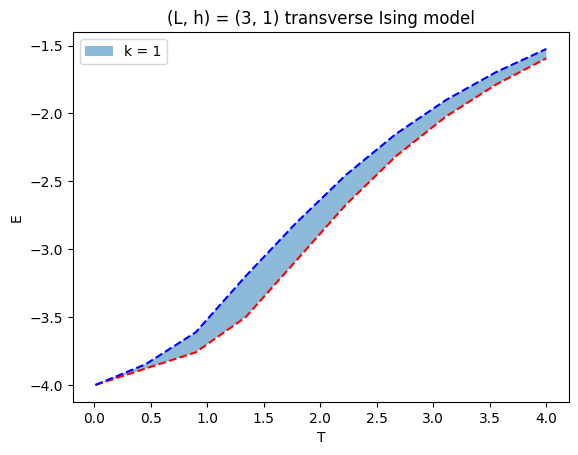

In [22]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, label=f'k = {k}')
plt.plot(1/betas, mins,c ='red',linestyle='--')
plt.plot(1/betas, maxs,c ='blue',linestyle='--')
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h) = ({L}, {h}) transverse Ising model')
plt.legend()
plt.show()